# Example 02: Simulation -- Training on Multiple Datasets

Simulation is the most common mode in system identification: the model predicts
output y(t) from input u(t) alone, with no access to past measured outputs. This
example trains simulation models on benchmark datasets and introduces
`InferenceWrapper` for numpy-based inference.

## Prerequisites

This notebook builds on concepts from Examples 00 and 01. Make sure you are
familiar with creating DataLoaders and training a basic model before proceeding.

## Setup

In [1]:
import numpy as np
from tsfast.datasets.benchmark import create_dls_silverbox, create_dls_wh
from tsfast.models.rnn import RNNLearner
from tsfast.inference import InferenceWrapper
from tsfast.learner.losses import fun_rmse

## What is Simulation?

In simulation mode, the model sees **only the input signal** u(t) and must predict
the output y(t). The model has no access to measured outputs -- it must simulate
the system's behavior purely from the input.

This is the simplest and most common mode for system identification. Think of it
as a black-box model that takes a control signal and predicts what the system will
do, without ever "peeking" at the real measurements during inference.

## Load the Silverbox Dataset

The Silverbox is a standard benchmark in system identification. It is an
electronic circuit that mimics a nonlinear mass-spring-damper system.

- `bs=16`: batch size of 16 windows per training step
- `win_sz=500`: each training window is 500 timesteps long
- `stp_sz=10`: consecutive windows are offset by 10 timesteps (overlapping windows)

In [2]:
dls = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)

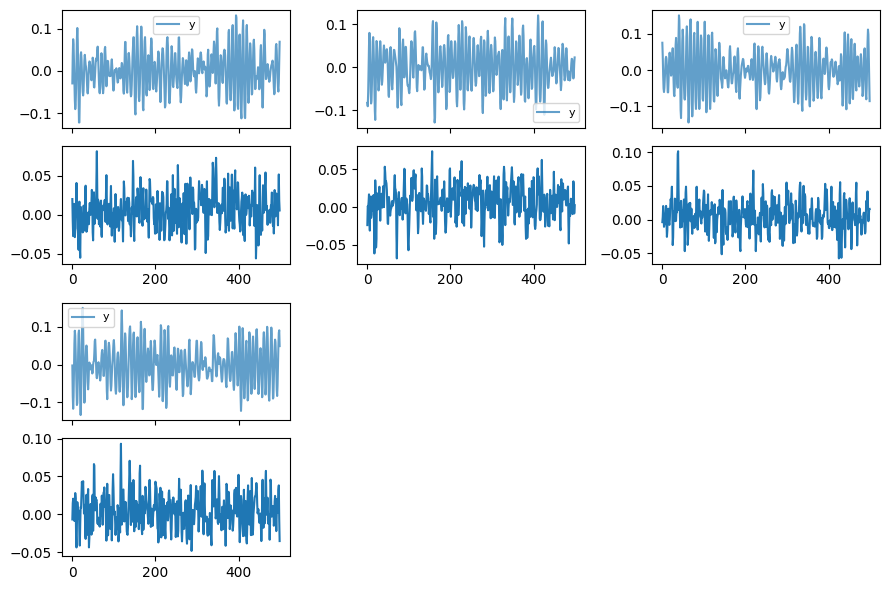

In [3]:
dls.show_batch(max_n=4)

## Train an LSTM with n_skip

RNNs start with a zero hidden state, so the first N predictions are unreliable
because the network hasn't "warmed up" yet. The `n_skip` parameter excludes the
first N timesteps from the loss computation, so the model isn't penalized for the
transient warmup period.

Key parameters:

- `rnn_type='lstm'`: use an LSTM cell (alternatives: `'gru'`, `'rnn'`)
- `n_skip=50`: exclude the first 50 timesteps from the loss
- `hidden_size=40`: 40 hidden units in the LSTM layer
- `metrics=[fun_rmse]`: track root mean squared error during training

In [4]:
lrn = RNNLearner(dls, rnn_type='lstm', n_skip=50, hidden_size=40, metrics=[fun_rmse])
lrn.fit_flat_cos(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.004972,0.003890,0.006263,00:03
1,0.002811,0.003683,0.004859,00:03
2,0.002426,0.002775,0.003735,00:03
3,0.002315,0.003012,0.004053,00:03
4,0.002546,0.005181,0.006502,00:03
5,0.001971,0.002799,0.003800,00:02
6,0.002145,0.002377,0.003308,00:01
7,0.002244,0.001966,0.002796,00:02
8,0.001170,0.000969,0.002010,00:02
9,0.000791,0.000784,0.001937,00:01


## Visualize Results

`show_results` overlays the model's predictions against the true output on
validation windows. The model has never seen these windows during training.

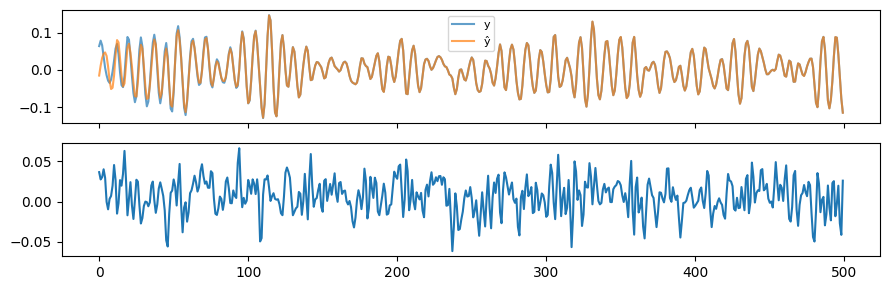

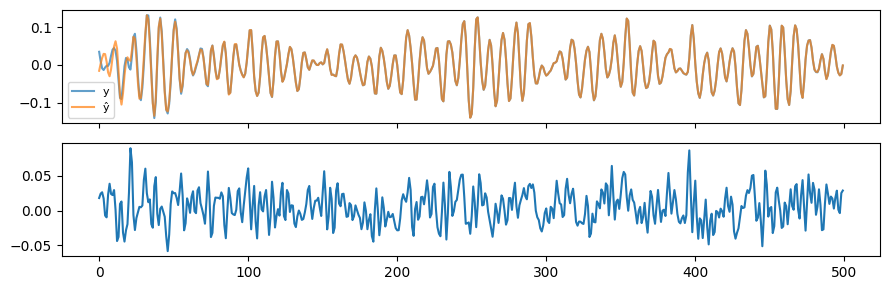

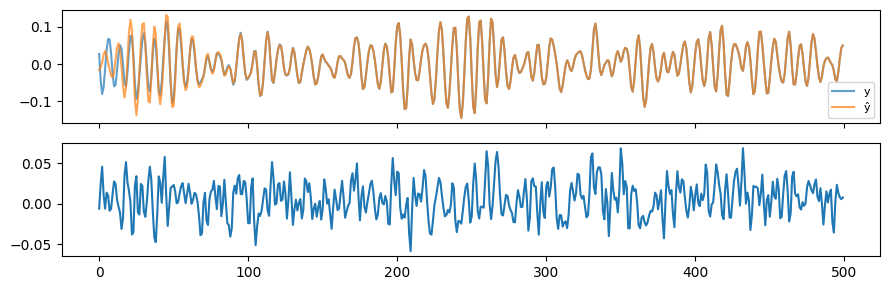

In [5]:
lrn.show_results(max_n=3)

## Evaluating on Different Data Splits

tsfast DataLoaders can hold multiple data splits from the benchmark:

- `ds_idx=0`: training set
- `ds_idx=1`: validation set
- `ds_idx=2` and above: test sets (if the benchmark provides them)

Use `validate()` to compute the loss and metrics on any split.

In [6]:
val_loss = lrn.validate(ds_idx=1)
print(f"Validation loss: {val_loss}")

Validation loss: [0.0007836779113858938, 0.001936824875883758]


## Getting Predictions

`get_preds` returns a tuple of `(predictions, targets)` as tensors. This is
useful for custom analysis, plotting, or computing metrics that aren't built
into tsfast.

In [7]:
preds, targs = lrn.get_preds(ds_idx=1)
print(f"Predictions shape: {preds.shape}")
print(f"Targets shape: {targs.shape}")

Predictions shape: torch.Size([30, 500, 1])
Targets shape: torch.Size([30, 500, 1])


## Training on a Different Dataset

The same workflow applies to any benchmark dataset. Here we train on the
Wiener-Hammerstein benchmark, which models a different nonlinear dynamic system.
The only change is the DataLoader factory function -- the model architecture
and training loop are identical.

In [8]:
dls_wh = create_dls_wh()
lrn_wh = RNNLearner(dls_wh, rnn_type='lstm', n_skip=50, hidden_size=40, metrics=[fun_rmse])
lrn_wh.fit_flat_cos(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.013670,0.011252,0.014554,00:02
1,0.008794,0.007500,0.010025,00:02
2,0.007920,0.007238,0.009374,00:02
3,0.005379,0.005439,0.007266,00:02
4,0.006003,0.008381,0.010919,00:02
5,0.005561,0.004734,0.006357,00:02
6,0.005425,0.009847,0.011024,00:03
7,0.004746,0.005673,0.007303,00:03
8,0.002511,0.001942,0.002870,00:03
9,0.001610,0.001687,0.002557,00:03


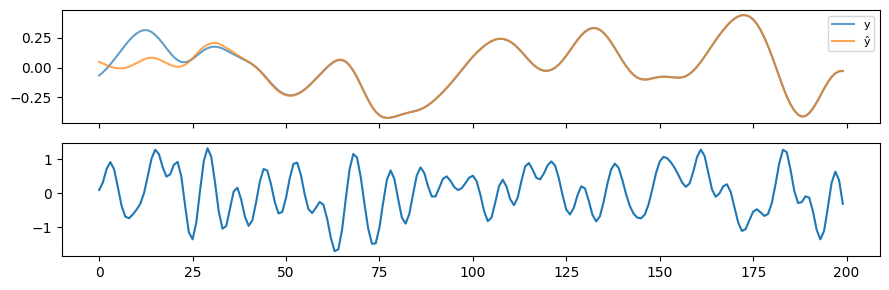

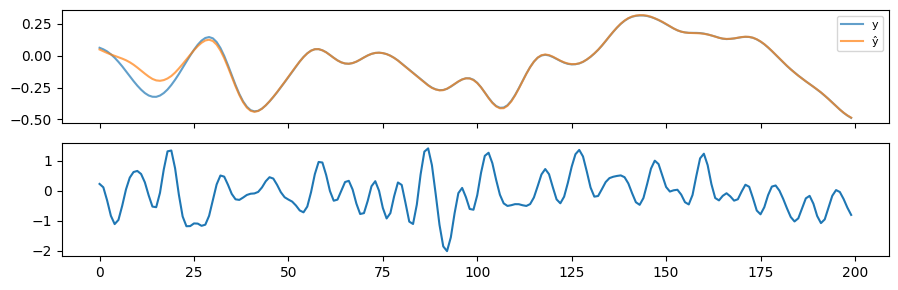

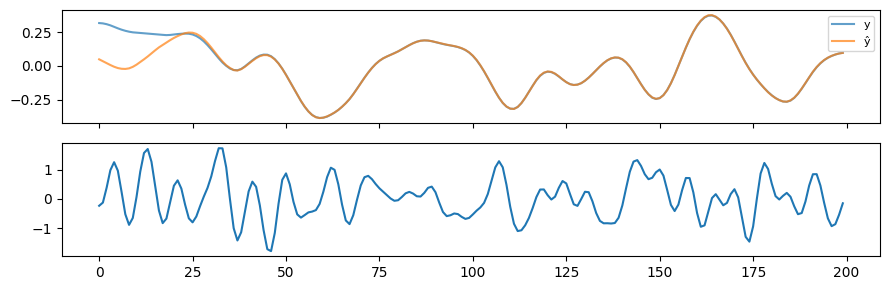

In [9]:
lrn_wh.show_results(max_n=3)

## Using Your Model: InferenceWrapper

After training, you often want to run inference with numpy arrays -- for example,
in a deployment pipeline or when integrating with scipy/control toolboxes.

`InferenceWrapper` handles the full pipeline automatically:

1. Converts numpy input to a PyTorch tensor
2. Applies the same input normalization used during training
3. Runs the model forward pass
4. Converts the output back to a numpy array

In [10]:
wrapper = InferenceWrapper(lrn)

xb, yb = dls.valid.one_batch()
np_input = xb.cpu().numpy()

y_pred = wrapper.inference(np_input)
print(f"Input shape:  {np_input.shape}")
print(f"Output shape: {y_pred.shape}")

Input shape:  (16, 500, 1)
Output shape: (16, 500, 1)


## Key Takeaways

- **Simulation models predict output from input alone** (no output feedback).
  The model must learn the full system dynamics from the excitation signal u(t).
- **`n_skip` handles the RNN warmup transient** by excluding early timesteps from
  the loss, so the model isn't penalized while its hidden state initializes.
- **`ds_idx` selects which data split to evaluate**: 0 = train, 1 = valid,
  2+ = test sets from the benchmark.
- **`InferenceWrapper` provides numpy-in / numpy-out inference** with automatic
  normalization, making it easy to use trained models outside of the training loop.